In [5]:
#!/usr/bin/env python
import dendropy
from dendropy.calculate import treecompare
import logging
from collections import defaultdict
import itertools
import random
import math
import copy
import sys

""" A module to compute the Robinson Foulds distance extended to topologies
which include speciation and duplication nodes

:author: Christophe Dessimoz
:institute: University of Lausanne

"""

def computeLRF(intree1,intree2):
    """
    Function to compute exactly the Labeled Robinson-Foulds (LRF) distance.

    Trees need to have their inner nodes with a label attribute "speciation"
    or "duplication". To correctly process gene trees from Ensembl, use the
    :func:`parseEnsemblLabels`.

    :param intree1: a labeled tree as Dendropy object
    :param intree2: a labeled tree as Dendropy object
    """

    # This implementation builds upon the datastructure and ideas of
    #    William HE Day, Optimal algorithms for comparing trees with 
    #    labeled leaves
    #    J Classification 2:7–28. 1985. doi: 10.1007/BF01908061


    # Define the table X  according to (Day 1985) to have contiguous integers for
    # each clade, and define a clade by the left-most and right-most identifiers,
    # such as [4,7] for the clade [4,5,6,7].
    # 
    # Note we extend the table to contain the following fields, which will be 
    # populated later in the algorithm:
    #  3: node defining the clade in T1
    #  4: node defining the clade in T2 
    #  5: size of the island rooted in the clade in T1
    #  6: size of the island rooted in the clade in T2 
    #  7: labels in the island rooted in the clade in T1
    #  8: labels in the island rooted in the clade in T2
    def buildX(T):
        X = []
        n = len(T.leaf_nodes())
        tax2id = {}
        n2bip = {}

        def buildX_r(T):
            if T.is_leaf():
                # left right id2taxon nodeT1 nodeT2 sizeIsland1 sizeIsland2 labels1 labels2
                X.append([0,0,T.taxon,0,0,0,0,set(),set()])
                i = len(X)-1
                tax2id[T.taxon] = i
                return(i,i)
            else:
                min_l=n
                max_r=0
                for c in T.child_node_iter():
                    l,r = buildX_r(c)
                    min_l=min(l,min_l)
                    max_r=max(r,max_r)
                X[min_l][0]=X[max_r][0]=min_l
                X[min_l][1]=X[max_r][1]=max_r
                X[min_l][3]=X[max_r][3]=T
                n2bip[T]=[min_l,max_r]
                return(min_l,max_r)
        buildX_r(T.seed_node)
        return(X,tax2id,n2bip)

    # findgood() identifies the good edge in T2 and generates the 
    # node-to-clade hash table 
    def findgood(T,X,tax2id):
        n2bip = {}
        n = len(T.leaf_nodes())
        def findgood_r(t):
            if t.is_leaf():
                i = tax2id[t.taxon]
                return(i,i,1)
            else:
                min_l=n
                max_r=0
                tot_w=0 
                for c in t.child_node_iter(): 
                    l,r,w = findgood_r(c)
                    min_l=min(l,min_l)
                    max_r=max(r,max_r)
                    tot_w+=w
                if max_r-min_l+1 == tot_w:
                    if (X[min_l][0]==min_l and X[min_l][1]==max_r):
                        X[min_l][4]=t
                        n2bip[t]=[min_l,max_r]
                    elif (X[max_r][0]==min_l and X[max_r][1]==max_r):
                        X[max_r][4]=t
                        n2bip[t]=[min_l,max_r]
                return(min_l,max_r,tot_w)
        findgood_r(T.seed_node)
        return(n2bip)

    # this function is used to identify the islands and update the table X 
    # with the relevant labels and sizes
    def getIslandsDay(t,X,n2bip,isT1):

        # An island is separated from the rest of the tree
        # by good edges. In the traversal below, we do a preorder
        # traversal and create a new island whenever we meet a clade
        # defined in X
        #                         ____
        #                        /
        #                 **** x6
        #                *       \___
        #         **** x3                ......
        #        *       \___    ______x7
        #   ----x1              /        ...
        #        *       **** x4        ____
        #         **** x2       ``--    /
        #                *********** x5
        #                              \_____
        #

        n = len(X)
        off = 5 if isT1 else 6

        def mytraversal(t,is_rooted,parentIslandId=0):

            if t.is_leaf():
                return()
            try:
                [l,r] = n2bip[t]
            except KeyError:
                l=r=0 #dummy value that will fail retrieval in X

            row=-1
            if (X[l][0]==l and X[l][1]==r and X[l][4]!=0):
                row=l
            elif (X[r][0]==l and X[r][1]==r and X[r][4]!=0):
                row=r

            # clade is in common (i.e. valid entry in X)
            if row > -1: 
                # end of previous island, so new island. 
                islandId = row
                X[row][off+2].add(t.label) 
                for c in t.child_node_iter():
                    mytraversal(c,is_rooted,islandId)
            else:
                # continue previous island
                islandId = parentIslandId
                # we process the node unless it's the fake root of an unrooted tree:
                if not is_rooted and len(t.adjacent_nodes()) == 2:
                    if t.label != None:
                        warnings.warn('The root of an unrooted tree should not have a label')
                else:
                    X[islandId][off+2].add(t.label) 
                    X[islandId][off] += 1 

                for c in t.child_node_iter():
                    mytraversal(c,is_rooted,islandId)

        mytraversal(t.seed_node, t.is_rooted)
        return()

    # check that the taxon namespace is consistent
    if intree1.taxon_namespace != intree2.taxon_namespace:
        raise ValueError('Cannot compare trees defined with different taxon_namespace')
    else:
        taxa = intree1.taxon_namespace

    # convert unrooted to rooted trees
    if not intree1.is_rooted and not intree2.is_rooted:
        t1=intree1.clone(depth=1)
        t2=intree2.clone(depth=1)
        
        node_n1 =t1.find_node_for_taxon(taxa[-1])
        t1.reroot_at_edge(node_n1.edge)
        t1.prune_taxa([taxa[-1]])
        node_n2 = t2.find_node_for_taxon(taxa[-1])
        t2.reroot_at_edge(node_n2.edge)
        t2.prune_taxa([taxa[-1]])
        
    elif intree1.is_rooted and intree2.is_rooted:
        t1=intree1.clone(depth=1)
        t2=intree2.clone(depth=1)
    else:
        raise TypeError('Cannot compare a rooted tree with an unrooted tree.')

    X, tax2id, n12bip = buildX(t1)
    n22bip = findgood(t2,X,tax2id)
    getIslandsDay(t1,X,n12bip,True)
    getIslandsDay(t2,X,n22bip,False)
    rf = subs = 0
    for i in X:
        if i[4] != 0:
            rf += i[5]+i[6]
            if len(i[7].intersection(i[8])) == 0:
                subs +=1
    
    logging.info('RF dist: %d | Label subst: %d | Total LRF: %d\n' % (rf,subs,rf+subs))
    return(rf+subs)



# this is a previous implementation based on bipartition vectors
# It is superseeded by the above version, O(n), which uses the
# perfect hashing scheme of Day 1985 to index the clades
def computeLRF_old(intree1,intree2):
           
    t1 = intree1.clone()
    t2 = intree2.clone()

    b1,bTn1 = identify_labelled_bipartitions(t1)
    b2,bTn2 = identify_labelled_bipartitions(t2)

    goodedges = set(b1).intersection(set(b2))

    # retrieve the islands (including trivial ones)
    islands1, node_island1, sizeIsland1 = getIslands(t1,goodedges)
    islands2, node_island2, sizeIsland2 = getIslands(t2,goodedges)
    logging.debug("islands 1: "+ str(islands1))
    logging.debug("islands 2: "+ str(islands2))

    if len(islands1) != len(islands2):
        raise ValueError('Unequal number of islands. Should not happen.')

    # keep track of processed islands
    processed1 = [False]*len(islands1)
    processed2 = [False]*len(islands2)
    rf = sub = 0

    # go through all goodedges, and use them to match islands on either side
    for i in goodedges:

        # only will match based one the child node of the goodedge
        n1 = bTn1[i][0] if bTn1[i][0].parent_node == bTn1[i][1] else bTn1[i][1]
        n2 = bTn2[i][0] if bTn2[i][0].parent_node == bTn2[i][1] else bTn2[i][1]

        logging.debug("Matching Islands: %s %s" % (n1.bipartition.leafset_as_bitstring(),n1.bipartition.split_as_bitstring()))
        logging.debug("Matching Islands: %s %s" % (n2.bipartition.leafset_as_bitstring(),n2.bipartition.split_as_bitstring()))

        # note the difference between leafset_bitmask and split_bitmask in dendropy
        if n1.bipartition.leafset_bitmask == n2.bipartition.leafset_bitmask:
            i1 = node_island1[n1]
            i2 = node_island2[n2]
            i3 = node_island1[n1.parent_node]
            i4 = node_island2[n2.parent_node]
        else: # we might need to swap due to the trees being in different rotations
            i1 = node_island1[n1]
            i2 = node_island2[n2.parent_node]
            i3 = node_island1[n1.parent_node]
            i4 = node_island2[n2]

        if not processed1[i1]:
            rf += sizeIsland1[i1] + sizeIsland2[i2] - 2
            if sizeIsland1[i1] > 1 or sizeIsland2[i2] > 1:
                logging.info('Collapses needed between islands %d and %d: %d+%d' % (i1,i2,sizeIsland1[i1]-1,sizeIsland2[i2]-1))
            logging.debug(islands1[i1],islands2[i2])
            if len(islands1[i1].intersection(islands2[i2])) == 0:
                logging.info('Substitution needed between %d and %d' % (i1,i2))
                sub += 1
            processed1[i1] = processed2[i2] = True
        if not processed1[i3]:
            rf += sizeIsland1[i3] + sizeIsland2[i4] - 2
            if sizeIsland1[i3] > 1 or sizeIsland2[i4] > 1:
                logging.info('Collapses needed between islands %d and %d: %d+%d' % (i3,i4,sizeIsland1[i3]-1,sizeIsland2[i4]-1))

            logging.debug(islands1[i3],islands2[i4])
            if len(islands1[i3].intersection(islands2[i4])) == 0:
                logging.info('Substitution needed between %d and %d' % (i3,i4))
                sub += 1
            processed1[i3] = processed2[i4] = True

    # if there is no good edge at all, there should be one island on each side
    if False in processed1:
        logging.debug('Not a single good edge, so need to match the sole islands')
        if len(islands1) != 1:
            raise ValueError('Multiple islands not processed. Should not happen. '+str(len(islands1)))
        rf += sizeIsland1[0] + sizeIsland2[0] - 2
        if sizeIsland1[0] > 1 or sizeIsland2[0] > 1:
            logging.info('Collapses needed between two stars: %d+%d' % (sizeIsland1[0]-1,sizeIsland2[0]-1))

        if len(islands1[0].intersection(islands2[0])) == 0:
            sub += 1
            logging.info('Substitution needed between the two stars')
    elif False in processed2:
        raise ValueError('At least one unprocessed island in t2 remaining. Should not happen.')

    return(rf+sub)

def getIslands(t,goodedges):

    #                         ____
    #                        /
    #                 **** x6
    #                *       \___
    #         **** x3                ......
    #        *       \___    ______x7
    #   ----x1              /        ...
    #        *       **** x4        ____
    #         **** x2       ``--    /
    #                *********** x5
    #                              \_____
    #


    # the list island contains at position i the set of labels associated with the ith island
    islands = [set()]
    # node_island is a dictionary of nodes -> island map
    node_island = {}
    countIsland = 0
    sizeIslands = [0]

    def mytraversal(t,is_rooted,parentIslandId=0):
        nonlocal goodedges, islands, node_island, countIsland

        if t.is_leaf():
            return()


        if t.bipartition in goodedges:
            # end of previous island, so new island. Cannot be the root
            islandId = countIsland = countIsland+1
            islands.append({t.label})
            sizeIslands.append(1)
            node_island[t]=islandId
            for c in t.child_node_iter():
                mytraversal(c,is_rooted,islandId)
        else:
            # continue previous island
            islandId = parentIslandId
            # we process the node unless it's the fake root of an unrooted tree:
            if not is_rooted and len(t.adjacent_nodes()) == 2:
                if t.label != None:
                    warnings.warn('The root of an unrooted tree should not have a label')
            else:
                islands[islandId].add(t.label)
                sizeIslands[islandId]+=1
            node_island[t]=islandId

            for c in t.child_node_iter():
                mytraversal(c,is_rooted,islandId)

    mytraversal(t.seed_node, t.is_rooted)
    return(islands,node_island,sizeIslands)


# def identify_labelled_bipartitions(t):
#
#     t.encode_bipartitions()
#
#     def recursive_f(n,bipart,bipart2nodes,numTaxa):
#         if n.is_leaf():
#             return
#         for c in n.child_node_iter():
#             if not c.is_leaf():
#                 numTaxaC = bin(c.bipartition.split_bitmask).count('1')
#                 numTaxaN = numTaxa - numTaxaC
#
#                 # at the start of the recursion, one subtree might contain all taxa
#                 # minus the other one so we must ignore this trivial bipartition
#                 if numTaxaN > 1:
#                     bipart.append(c.bipartition)
#                     bipart2nodes[c.bipartition] = [c,n]
#                 recursive_f(c,bipart,bipart2nodes,numTaxa)
# 
#     numTaxa = len(t.leaf_nodes())
#     bipart = []
#     bipart2nodes = {}
#     recursive_f(t.seed_node,bipart,bipart2nodes,numTaxa)
#     return(bipart,bipart2nodes)
#

def computeELRF(intree1,intree2):
    """
    Function to estimate the edge-based labeled Robinson-Foulds distance.
    This is a heuristic which returns an upper bound on the distance.

    Trees need to have their inner nodes with a label attribute "speciation"
    or "duplication". To correctly process gene trees from Ensembl, use the
    :func:`parseEnsemblLabels`.

    :param intree1: a labeled tree as Dendropy object
    :param intree2: a labeled tree as Dendropy object
    """
    t1 = intree1.clone()
    t2 = intree2.clone()
    b1,bTn1 = identify_labelled_bipartitions(t1)
    b2,bTn2 = identify_labelled_bipartitions(t2)


    # FIRST PART:  identifying the bipartitions unique to one or the other tree
    #              and collapsing the trivial edges
    tocollapse1 = []
    tocollapse2 = []
    simple_rf = tot_rf = path_flip = 0
    for k in set(b1).difference(set(b2)):
        logging.debug(k)
        # retrieve the nodes associated with the bipartition
        [c,n] = bTn1[k]
        if c.label == n.label:
            logging.debug('collapsing node %s' % c)
            c.edge.collapse()
            simple_rf += 1
        else:
            tocollapse1.append(k)
    logging.debug('---')
    for k in set(b2).difference(set(b1)):
        logging.debug(k)
        # retrieve the nodes associated with the bipartition
        [c,n] = bTn2[k]
        if c.label == n.label:
            logging.debug("collapsing node %s" % c)
            c.edge.collapse()
            simple_rf += 1
        else:
            tocollapse2.append(k)
    logging.debug('***')
    logging.info('step 1, collapse consist. edges  %d' % simple_rf)
    logging.info('        remaining to collapse:   {} and {}'.format(
        len(tocollapse1),len(tocollapse2)))


    logging.debug(t1.as_string("newick"))
    logging.debug(t2.as_string("newick"))

    # PART II:  identifying the connected components of edges to be
    #           collapsed and recording the ends of the longest path
    #
    # The idea of this function is to go from root to leaves,
    # and then, on the way back, compute the longest path of
    # each component to be collapsed.
    # Within each component, we need to keep track of three potential
    # cases:
    #  (1) the longest path spans over the edge (n.edge) in question,
    #      in which case its total length is still undetermined
    #  (2) the longest path spans over two of the children of n. In
    #      this case the length is known but the type needs to be
    #      determined
    #  (3) the longest path is found somewhere deeper. We need to keep
    #      track of its type.
    #
    # Note that the longest path is highlighted with ****
    #
    #                                   ------
    #                                 /
    #                     **************************
    #                   *
    #   ****n.edge**** n      (case 1)
    #                   \
    #                     -----------------
    #
    #                                   ------
    #                                 /
    #                     **************************
    #                   *
    #   ---n.edge---- n      (case 2)
    #                   *
    #                     **********************
    #
    #
    #                                   ************
    #                                 *
    #                     ------------**************
    #                   /
    #   ---n.edge---- n      (case 3)
    #                   \
    #                     ---------------

    def recursive_f(n,tocollapse,out):
        nonlocal path_flip
        if n.is_leaf():
            return([maxpath(),maxpath()])
        case1 = []
        case3 = []
        for c in n.child_node_iter():
            [t1,t3] = recursive_f(c,tocollapse,out)
            case1.append(t1)
            case3.append(t3)
        case1.sort(reverse=True)
        case3.sort(reverse=True)
        # do we need to collapse the edge in question?
        if n.bipartition in tocollapse:
            # if the maximum path goes over the edge n, we need
            # to increment the length in question
            newcase1 = copy.deepcopy(case1[0])
            if case1[0].length == 0:
                newcase1.n1 = copy.deepcopy(n)
            newcase1.length = newcase1.length + 1
            # if not, we keep track of the longest path in the component
            # seen so far (case 3)
            newcase3 = copy.deepcopy(case3[0])
            # if there are more than one child edge to collapse,
            # there is one last scenario, which is that the longest path
            # is obtained by connecting two children edges (case 2)
            if case1[0].length + case1[1].length > case3[0].length:
                # store the total length
                newcase3.length = case1[0].length+case1[1].length
                # store the end nodes
                newcase3.n1 = case1[0].n1
                newcase3.n2 = case1[1].n1
            return([newcase1,newcase3])
        else:
            # if one of the children was still part of a component,
            # we need to store it
            if sum([c.length for c in case1]) > 0:
                # we need to check what is the maximum length path
                if case1[0].length > case3[0].length:
                    # longest path is case 1 or case 2
                    if case1[1].length > 0:
                        # longest path is case 2
                        bestpath = maxpath(case1[0].length + case1[1].length, case1[0].n1, case1[1].n1)
                        if bestpath.length % 2 == 0:
                            assert bestpath.n1.label == bestpath.n2.label
                        else:
                            assert bestpath.n1.label != bestpath.n2.label
                    else:
                        bestpath = case1[0]
                        bestpath.n2 = copy.deepcopy(n)
                        # longest path is case 1
                        if bestpath.length % 2 == 0:
                            assert n.label == bestpath.n1.label
                        else:
                            assert n.label != bestpath.n1.label

                else:
                    # longest path is case3
                    bestpath = case3[0]

                path_flip += math.floor((bestpath.length+1)/2)
                out[n] = bestpath
                # determine type
                if bestpath.length % 2 == 0:
                    n.label = bestpath.n1.label
                else:
                    n.label = "arbitrary"
            # reset counts
            return([maxpath(),maxpath()])


    ob1 = ordered_bipartitions(t1)
    ob2 = ordered_bipartitions(t2)


    path_flip = 0
    tot_rf = simple_rf + len(tocollapse1) + len(tocollapse2)
    out1 = {}
    recursive_f(t1.seed_node,tocollapse1,out1)
    out2 = {}
    recursive_f(t2.seed_node,tocollapse2,out2)


    for n in t1.internal_nodes():
        if n.bipartition in tocollapse1:
            n.edge.collapse()
    for n in t2.internal_nodes():
        if n.bipartition in tocollapse2:
            n.edge.collapse()

    logging.info('step 2, #component t1            {}'.format(len(out1)))
    logging.debug(out1)
    logging.info('        #component t2            {}'.format(len(out2)))
    logging.debug(out2)
    logging.info('        #flips                   {}'.format(path_flip))

    #logging.info(t1.print_plot())

    logging.debug(t1.as_string("newick"))
    logging.debug(t2.as_string("newick"))

    ## PART 3:  flipping the nodes, if needed, and checking whether
    ##    arbitary vs arbitrary comparisons can save a flip by going
    ##    over an expansion instead of a contraction.

    ob1 = ordered_bipartitions(t1)
    ob2 = ordered_bipartitions(t2)

    def branches_at_end(path,tocollapse):
        tc1 = set([t.split_bitmask for t in tocollapse])

        s1 = [t.bipartition.split_bitmask for t in path.n1.child_nodes()]
        s1.append(path.n1.bipartition.split_bitmask)
        s1 = set(s1)
        s1 = s1.difference(tc1)

        s2 = [t.bipartition.split_bitmask for t in path.n2.child_nodes()]
        s2.append(path.n2.bipartition.split_bitmask)
        s2 = set(s2)
        s2 = s2.difference(tc1)

        # convention is return speciation, then duplication node
        if path.n1.label == 'speciation':
            return([s1,s2])
        else:
            return([s2,s1])

    # we use LRF for the final relabelling
    end_flip = computeLRF(t1,t2)
    logging.info('step 3, perform remaining flips: {} '.format(end_flip))


    erf = tot_rf+path_flip+end_flip
    logging.info('TOTAL:                           {}'.format(erf))
    return(erf)




def cloneAndReroot(t):
  t1 = t.clone(depth=1)
  # reroot around the edge leading to the first leaf
  l = next(t1.leaf_node_iter())
  t1.reroot_at_edge(l.incident_edges()[0])
  return(t1)


def identify_labelled_bipartitions(t):

    t.encode_bipartitions()

    def recursive_f(n,bipart,bipart2nodes,numTaxa):
        if n.is_leaf():
            return
        for c in n.child_node_iter():
            if not c.is_leaf():
                numTaxaC = bin(c.bipartition.split_bitmask).count('1')
                numTaxaN = numTaxa - numTaxaC

                # at the start of the recursion, one subtree might contain all taxa
                # minus the other one so we must ignore this trivial bipartition
                if numTaxaN > 1:
                    bipart.append(c.bipartition)
                    bipart2nodes[c.bipartition] = [c,n]
                recursive_f(c,bipart,bipart2nodes,numTaxa)

    numTaxa = len(t.leaf_nodes())
    bipart = []
    bipart2nodes = {}
    recursive_f(t.seed_node,bipart,bipart2nodes,numTaxa)
    return(bipart,bipart2nodes)


# a helpful datastructure to store a path
class maxpath(object):
    def __init__(self, length=0, n1=None, n2=None):
        self.length = length
        self.n1 = n1
        self.n2 = n2
    def __cmp__(self, other):
        return(cmp(self.length, other.length))
    def __lt__(self, other):
        return(self.length < other.length)
    def __eq__(self, other):
        return(self.length == other.length)
    def __str__(self):
        return('Path length: %d. Ends %s & %s' % (self.length, self.n1, self.n2))

def ordered_bipartitions(intree):
    tree = intree.clone()
    leaves_dic = {}
    for node in tree.internal_nodes():
        leaves_dic[tuple(sorted(nd.taxon.label for nd in dendropy.Tree(seed_node = node).leaf_nodes()))] = node
    return leaves_dic

def mutateLabeledTree(tree, n, p_flip=0.3, model='LRF'):
    """
    Function to perform random edits to labeled tree. For each ``n`` edit, the
    probability of a flip is specified by p_flip, and the rest of the
    probability density is evenly split among all potential edges to flip and
    all nodes with degree >3.
    Returns a new tree (leaves the input tree unchanged)

    :param tree: a labeled tree as Dendropy object
    :param n: number of edits
    :param p_flip: probability of flipping between "duplication" and "speciation" state (0.3 by default)
    :param model: either ELRF, which requires edge additions/removals to be between same types, or LRF (default), which has no such requirement.
    """
    t = tree.clone(depth=1)
    e = f = c = 0

    # if the root is of degree 2, collapse one of the two edges
    # (won't affect the topology, but this will ensure that further collapses are meaningful)
    t.update_bipartitions()
    logging.debug(t)
    for i in range(0, n):
        logging.debug(i)
        #potential nodes           
        potential_nodes_to_collapse = []
        potential_nodes_to_expand = []
        for n in t.internal_nodes():
            # for expansions and contractions, skip the (fake) root of an unrooted tree
            # which has only 3 children
            nch = len(n.child_edges());
            if n.parent_node == None and t.is_unrooted and nch == 3:
                continue
            if nch >= 3:
                potential_nodes_to_expand.append(n)
            # for contraction, skip any root node            
            if n.parent_node == None:           
                continue           
            if (n.label == n.parent_node.label and n.label != None) or model=='LRF':
                potential_nodes_to_collapse.append(n)        
        potential_nodes_to_flip = [n for n in t.internal_nodes() if n.label != None]
                                   
        ncol = len(potential_nodes_to_collapse) 
        nflip = len(potential_nodes_to_flip)    
        nexp = len(potential_nodes_to_expand)   
                                   
        if random.random() < p_flip:            
            flip_node(potential_nodes_to_flip[random.randint(0,nflip-1)]) 
            f += 1                 
        else:                      
            x = random.randint(0,ncol+nexp-1)   
            if x < ncol:           
                collapse_node(potential_nodes_to_collapse[x],model=model)
                c += 1             
            else:                  
                e += 1             
                extend_node(potential_nodes_to_expand[x-ncol],model=model)            
        logging.debug(t)           
    logging.info('#flips %s #col %s, #exp %s',f,c,e)         
    return(t)

def collapse_node(node,model='LRF'):
    logging.debug(node)
    if model == 'ELRF':
        if node.parent_node != None and node.label == node.parent_node.label:
            node.edge.collapse()
        else:
            raise ValueError('this edge cannot be collapsed without a flip!')
    elif model == 'LRF':
        node.edge.collapse()
    else:
        raise ValueError('unsupported model')

def flip_node(node):
    if node.label == 'speciation':
        node.label = 'duplication'
        node.annotations['D'].value = 'Y'
        node.annotations['DD'].value = 'Y'
    elif node.label == 'duplication':
        node.label = 'speciation'
        node.annotations['D'].value = 'N'
        node.annotations['DD'].value = 'N'
    else:
        raise ValueError('Should not happen!!')
        number = random.randint(1,2)
        if number == 1:
            node.label = "speciation"
            node.annotations['D'].value = 'N'
        node.annotations['DD'].value = 'N'
        if number == 2:
            node.label = "duplication"
            node.annotations['D'].value = 'Y'
        node.annotations['DD'].value = 'Y'

def extend_node(node, model='LRF'):
    if model not in ['LRF','ELRF']:
        raise ValueError('unsupported model')

    if (len(node.adjacent_nodes())<= 3 and node.parent_node != None) or len(node.adjacent_nodes())<= 2:
        print(node.adjacent_nodes(),node.incident_edges())
        raise ValueError("Insufficient degree. Should not happen ")
    # store the children in a temporary array
    children = node.child_nodes()
    # shuffle the array
    random.shuffle(children)

    node.clear_child_nodes()
    newlab = node.label if model == 'ELRF' else random.choice(['speciation','duplication'])
    new = node.add_child(dendropy.Node(label=node.label))
    # choose between 2 and n-1 children to be connected to the new node
    k = random.randint(2,len(children)-1)
    for i in range(0,len(children)):
        # add the first k
        if i < k:
            new.add_child(children[i])          
        else:
            node.add_child(children[i]) 


def parseEnsemblLabels(intree):
    """
    Function to convert a Dendropy tree obtained from Ensembl (in NHX) format.
    Returns a new tree (leaves the input tree unchanged)

    :param intree: a tree as Dendropy object
    """
    t = intree.clone(depth=1)
    for n in t.internal_nodes():
        if n.annotations['D'].value == 'Y' or n.annotations['DD'].value == 'Y':
            n.label = 'duplication'
        else:
            n.label = 'speciation'
    t.seed_node.label = None

    # if the tree is unrooted with root node of degree 2, turn into trifurcation
    # while keeping the correct state
    cn = t.seed_node.child_nodes()
    if not t.is_rooted and len(cn)==2:
        i = 1 if cn[0].is_leaf() else 0
        tmp = cn[i].label
        cn[i].edge.collapse()
        t.seed_node.label = tmp

    return(t)


def randomLabels(intree, p_speciation=0.7):
    """
    Function to assign random speciation and duplication nodes to a tree.
    Returns a new tree (leaves the input tree unchanged)

    :param intree: a tree as Dendropy object
    :param p_speciation: probability of a speciation node.
    """
    t = intree.clone(depth=1)
    for n in t.internal_nodes():
        if random.random() < p_speciation:
            n.label = 'speciation'
        else:
            n.label = 'duplication'
    t.seed_node.label = None
    return(t)



In [8]:
import unittest
import dendropy
import sys
import os
import random
import numpy as np

number_test = 100

taxa = dendropy.TaxonNamespace()

p53 = dendropy.Tree.get_from_path('./p53.nhx.txt', 
            'newick', taxon_namespace=taxa)

t1 = parseEnsemblLabels(p53)

cases = [
    { 'familly': 0,'num_mut':0,'LRF': 0, 'tree': t1.as_string('newick', annotations_as_nhx=True, suppress_annotations=False) }
]


mut = []


for n in range(1,number_test):
    
    case = {
        'familly': n,
        'num_mut': np.random.poisson(4),
    }
    
    mut.append(case['num_mut'])
        
    t2 = mutateLabeledTree(t1, case['num_mut'])
    case['tree'] = t2.as_string('newick', annotations_as_nhx=True, suppress_annotations=False)
    case['LRF'] = computeLRF(t1,t2)
    
    
    cases.append(case)




In [9]:
import json

with open('ut_LRF_3.json', 'w') as fp:
    json.dump(cases, fp)

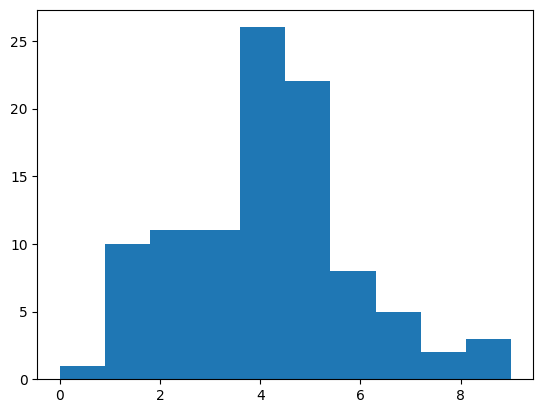

In [60]:
import matplotlib.pyplot as plt

plt.hist(mut)
plt.show()

In [1]:
t1

NameError: name 't1' is not defined